# UV Galaxies 2023: UV Nebular Properties Workshop

This notebook will walk through PyNeb, a useful tool for measuring nebular properties of gaseous nebulae. The focus will be on those properties that can be measured from the UV and optical.

## 1. Import Useful Packages

To start, import useful Python packages:

In [1]:
import numpy as np
from numpy import loadtxt
from numpy import random
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math as m

import scipy
import scipy.optimize as optimize

random.seed(2401)
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


Next, import PyNeb:

In [2]:
import pyneb as pn

To perform many calculations useful for nebular astrophysics, PyNeb defines different classes and functions within these classes. For example, the "Atom" class refers to the different ions found in an H II region. Functions contained within this class include printing transitions and the Grotrian diagram for this ion, determining the critical density of a given transition, etc.

To begin, it is useful to define the atomic data for each ion. In the dictionary below, each key refers to an ions and contains a dictionary with the following info: the atomic transition probabilities, the collision strengths, and the recombination rates. These can be adjusted as necessary; PyNeb provides many atomic data files from different references, but a user can create their own as long as the file structure is followed. If no atomic data files are provided, PyNeb reverts to a default set of atomic data for a given ion.

In [3]:
DataFileDict = {'C3':  {'atom':'c_iii_atom_G83-NS78-WFD96.dat',  'coll':'c_iii_coll_Bal85.dat'},
                'C4':  {'atom':'c_iv_atom_WFD96.dat',  'coll':'c_iv_coll_AK04.dat'},
                'N2':  {'atom':'n_ii_atom_FFT04.dat',  'coll':'n_ii_coll_T11.dat'},
                'O2':  {'atom':'o_ii_atom_FFT04.dat',  'coll':'o_ii_coll_Kal09.dat', 'rec':'o_ii_rec_P91.func'},
                'O3':  {'atom':'o_iii_atom_FFT04.dat','coll': 'o_iii_coll_AK99.dat'},   
                'Ne3': {'atom':'ne_iii_atom_FFT04.dat','coll':'ne_iii_coll_McLB00.dat'},
                'Ar3': {'atom':'ar_iii_atom_MZ83.dat', 'coll':'ar_iii_coll_MB09.dat'},
                'Ar4': {'atom':'ar_iv_atom_MZ82.dat', 'coll':'ar_iv_coll_RB97.dat'},
                'S2':  {'atom':'s_ii_atom_IFF05.dat',  'coll':'s_ii_coll_TZ10.dat'},   
                'S3':  {'atom':'s_iii_atom_FFTI06.dat', 'coll':'s_iii_coll_HRS12.dat'},
                'Fe2': {'atom':'fe_ii_atom_B15.dat', 'coll':'fe_ii_coll_B15.dat'},
                'C2':  {'rec':'c_ii_rec_D00.func'}} 
pn.atomicData.setDataFileDict(DataFileDict)

Next, define the Atom classes for the ions. Here, we define those that are often observed in the optical and UV that we will use to obtain the nebular properties.

In [4]:
C3  = pn.Atom('C',3) # For lines from [C III]
C4  = pn.Atom('C',4) # For lines from [C IV]
O2  = pn.Atom('O',2) # For lines from [O II]
O3  = pn.Atom('O',3) # For lines from [O III]
Si3 = pn.Atom('Si',3) # For lines from [Si III]
S2  = pn.Atom('S',2) # For lines from [S II]
S4  = pn.Atom('S',4) # For lines from [S IV]

Recombining ions are handled with their own class in PyNeb. A few of these are defined below.

In [5]:
H1 = pn.RecAtom('H',1) # For lines from H I
He2 = pn.RecAtom('He',2) # For lines from He II
C2 = pn.RecAtom('C',2) # For lines from C II

# 2. Working with the Atom Class

With our atom classes defined, let's explore what we can do with them.

## 2.1 Grotrian Diagrams

First, let's plot the Grotrian diagram for a few of the most commonly-observed ions in the UV. To do so, we use the plotGrotrian() function on a given atom class. For [O III]:

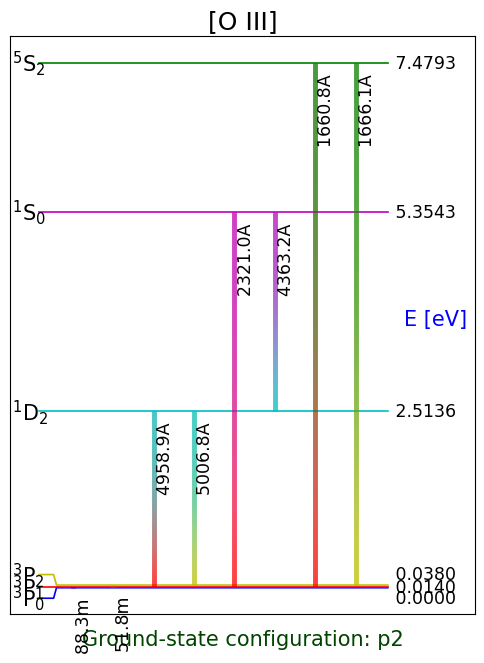

In [6]:
plt.rcParams.update({'font.size': 15})
f, ax = plt.subplots(figsize=(6,7.5))
O3.plotGrotrian(unit = 'eV', ax=ax)

The above Grotrian diagram shows the most intense emission lines from the [O III] ion. The energy levels are denoted on the right, and the wavelengths of the emission lines are provided for each transition. This diagram does not provide all [O III] transitions because some of the emission lines are not expected to be observed based on their small emissivities. By default, the emission lines are those that have emissivities > 10$^{-3}$ times the emissivity of the most intense emission line at $T_e$ = 1e4 K and $n_e$ = 100 cm$^{-3}$. If we want to plot all emission lines, we can update thresh_int to 0:

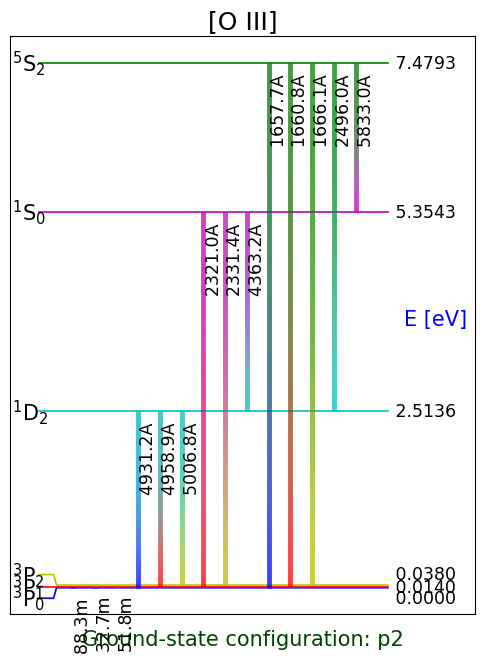

In [7]:
plt.rcParams.update({'font.size': 15})
f, ax = plt.subplots(figsize=(6,7.5))
O3.plotGrotrian(thresh_int=0, unit = 'eV', ax=ax)

Another example of a Grotrian diagram, this time for [C III]:

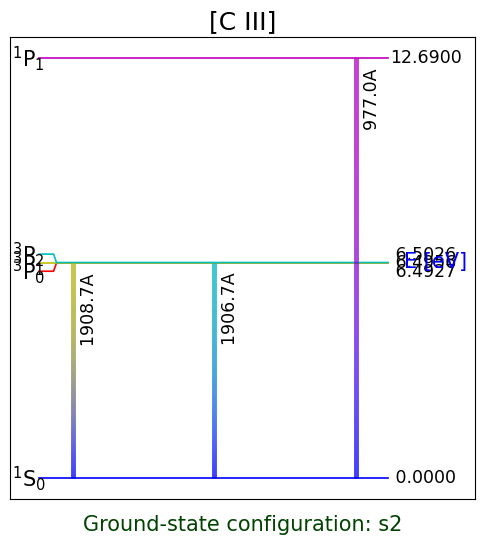

In [8]:
plt.rcParams.update({'font.size': 15})
f, ax = plt.subplots(figsize=(6,6))
C3.plotGrotrian(unit = 'eV', ax=ax)

## 2.2 Emissivities

To see how we can measure nebular properties from UV emission lines, we first plot the emissivities of different transitions. The emissivity describes the amount photons expected per ion from the transition and, as such, is a function of the electron gas properties $T_e$ and $n_e$. While PyNeb has built in functions for these plots, here we can focus on the emissivity of specific transitions; plotting the emissivity of these [O III] transitions as a function of $T_e$ and $n_e$:

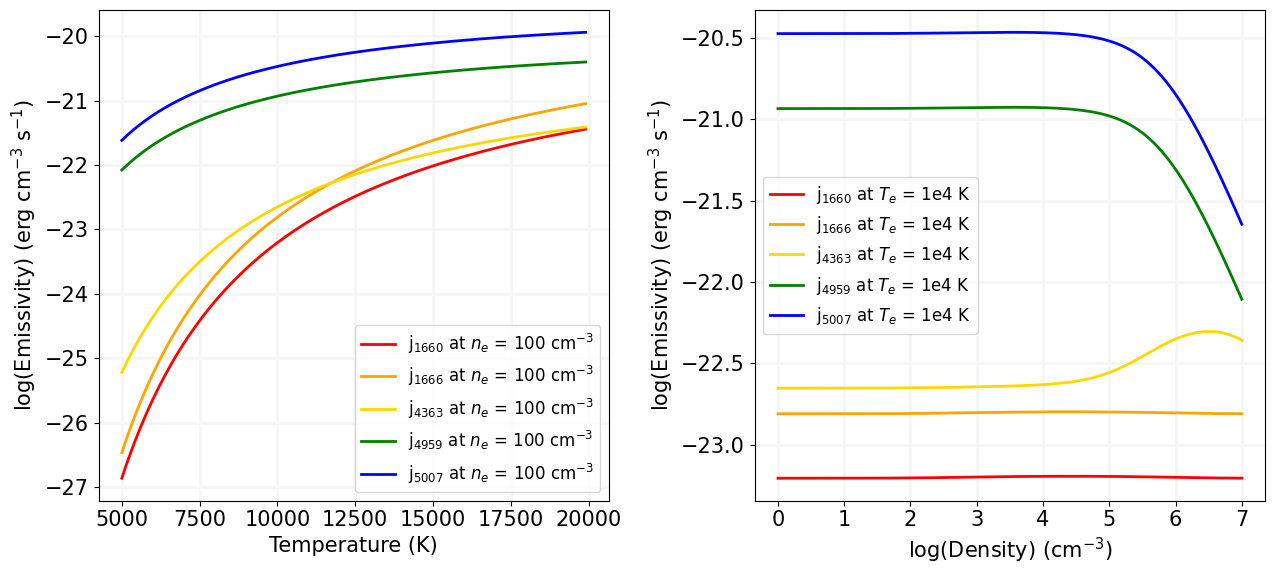

In [9]:
tRang = np.arange(5000,20000,100) # Define a range of temperatures
dRangL= np.arange(1e0,1e3,1e1)
dRangI= np.arange(1e3,1e5,1e2)
dRangH= np.arange(1e5,1e7,1e3)
dRang = np.concatenate((dRangL,dRangI,dRangH)) # Define a range of densities

em1660t = O3.getEmissivity(tRang,1e2,wave=1660.0) # Emissivity as a function of temperature at ne = 100 cm^-3
em1666t = O3.getEmissivity(tRang,1e2,wave=1666.1) # Emissivity as a function of temperature at ne = 100 cm^-3
em4363t = O3.getEmissivity(tRang,1e2,wave=4363.2) # Emissivity as a function of temperature at ne = 100 cm^-3
em4959t = O3.getEmissivity(tRang,1e2,wave=4958.9) # Emissivity as a function of temperature at ne = 100 cm^-3
em5007t = O3.getEmissivity(tRang,1e2,wave=5006.8) # Emissivity as a function of temperature at ne = 100 cm^-3

em1660d = O3.getEmissivity(1e4,dRang,wave=1660.0) # Emissivity as a function of density at Te = 1e4 K
em1666d = O3.getEmissivity(1e4,dRang,wave=1666.1) # Emissivity as a function of density at Te = 1e4 K
em4363d = O3.getEmissivity(1e4,dRang,wave=4363.2) # Emissivity as a function of density at Te = 1e4 K
em4959d = O3.getEmissivity(1e4,dRang,wave=4958.9) # Emissivity as a function of density at Te = 1e4 K
em5007d = O3.getEmissivity(1e4,dRang,wave=5006.8) # Emissivity as a function of density at Te = 1e4 K

#==========================================
plt.figure(figsize=(13,6))
fsize = 15

plt.subplot(1,2,1)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.plot(tRang,np.log10(em1660t),c='red',lw=2,label=r'j$_{1660}$ at $n_e$ = 100 cm$^{-3}$')
plt.plot(tRang,np.log10(em1666t),c='orange',lw=2,label=r'j$_{1666}$ at $n_e$ = 100 cm$^{-3}$')
plt.plot(tRang,np.log10(em4363t),c='gold',lw=2,label=r'j$_{4363}$ at $n_e$ = 100 cm$^{-3}$')
plt.plot(tRang,np.log10(em4959t),c='green',lw=2,label=r'j$_{4959}$ at $n_e$ = 100 cm$^{-3}$')
plt.plot(tRang,np.log10(em5007t),c='blue',lw=2,label=r'j$_{5007}$ at $n_e$ = 100 cm$^{-3}$')

plt.xlabel('Temperature (K)',fontsize=fsize)
plt.ylabel('log(Emissivity) (erg cm$^{-3}$ s$^{-1}$)',fontsize=fsize)

plt.legend(fontsize=fsize-3)

#==========================================

plt.subplot(1,2,2)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.plot(np.log10(dRang),np.log10(em1660d),c='red',lw=2,label=r'j$_{1660}$ at $T_e$ = 1e4 K')
plt.plot(np.log10(dRang),np.log10(em1666d),c='orange',lw=2,label=r'j$_{1666}$ at $T_e$ = 1e4 K')
plt.plot(np.log10(dRang),np.log10(em4363d),c='gold',lw=2,label=r'j$_{4363}$ at $T_e$ = 1e4 K')
plt.plot(np.log10(dRang),np.log10(em4959d),c='green',lw=2,label=r'j$_{4959}$ at $T_e$ = 1e4 K')
plt.plot(np.log10(dRang),np.log10(em5007d),c='blue',lw=2,label=r'j$_{5007}$ at $T_e$ = 1e4 K')

plt.xlabel(r'log(Density) (cm$^{-3}$)',fontsize=fsize)
plt.ylabel('log(Emissivity) (erg cm$^{-3}$ s$^{-1}$)',fontsize=fsize)

plt.legend(fontsize=fsize-3)

plt.tight_layout()

The transitions of [O III] plotted above are clearly strong functions of $T_e$ (left panel), but not as sensitive to $n_e$ (right panel). This is because the chosen transitions have high critical densities, defined as the density at which the rate of collisional deexcitations in the electron gas balances the rate of spontanteous deexcitation. For $n_e$ << the ciritcal density, the emissivity is not a strong function of $n_e$. Each energy level has a unique critical density, which can be accessed for a given temperature with the Atom class function getCriticalDensity:

In [10]:
#Print critical density of the [O III] energy levels at Te=1e4 K
cDenArr = O3.getCritDensity(1e4)
print('Critical Density for 1st Energy Level of [O III]: %3.3e' % cDenArr[0])
print('Critical Density for 2nd Energy Level of [O III]: %3.3e' % cDenArr[1])
print('Critical Density for 3rd Energy Level of [O III]: %3.3e' % cDenArr[2])
print('Critical Density for 4th Energy Level of [O III]: %3.3e' % cDenArr[3])
print('Critical Density for 5th Energy Level of [O III]: %3.3e' % cDenArr[4])
print('Critical Density for 6th Energy Level of [O III]: %3.3e' % cDenArr[5])

Critical Density for 1st Energy Level of [O III]: 0.000e+00
Critical Density for 2nd Energy Level of [O III]: 5.125e+02
Critical Density for 3rd Energy Level of [O III]: 3.581e+03
Critical Density for 4th Energy Level of [O III]: 7.143e+05
Critical Density for 5th Energy Level of [O III]: 2.730e+07
Critical Density for 6th Energy Level of [O III]: 4.195e+10


We can repeat the above for two transitions of [C III]:

Critical Density for 1st Energy Level of [C III]: 0.000e+00
Critical Density for 2nd Energy Level of [C III]: 0.000e+00
Critical Density for 3rd Energy Level of [C III]: 9.745e+08
Critical Density for 4th Energy Level of [C III]: 7.379e+04


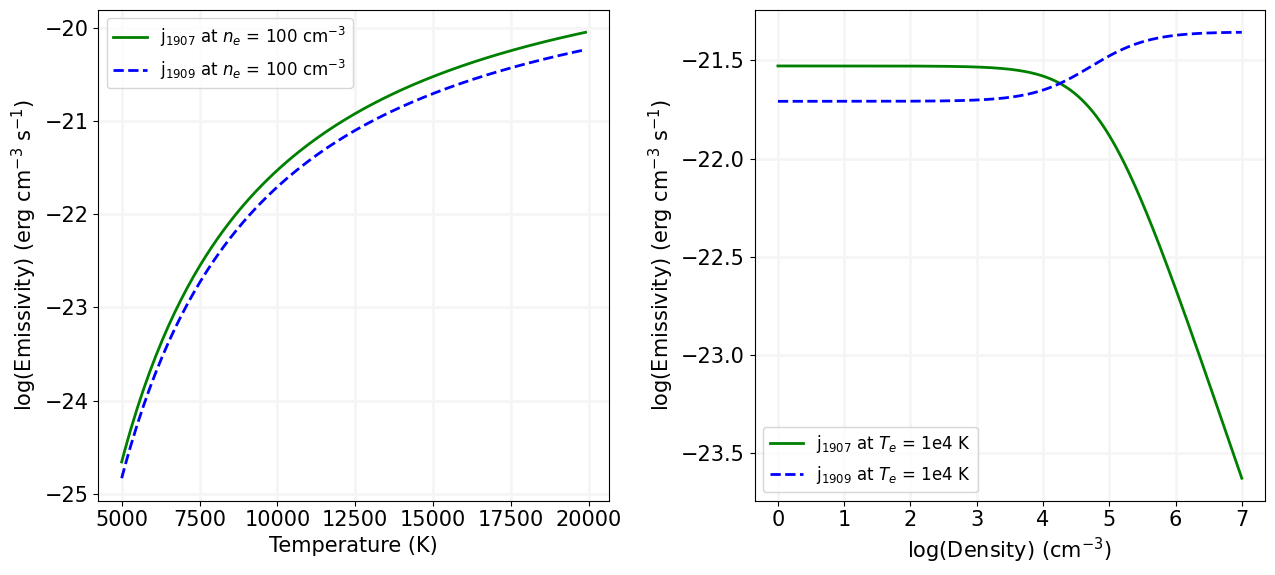

In [11]:
em1907t = C3.getEmissivity(tRang,1e2,wave=1907) # Emissivity as a function of temperature at ne = 100 cm^-3
em1909t = C3.getEmissivity(tRang,1e2,wave=1909) # Emissivity as a function of temperature at ne = 100 cm^-3

em1907d = C3.getEmissivity(1e4,dRang,wave=1907) # Emissivity as a function of density at Te = 1e4 K
em1909d = C3.getEmissivity(1e4,dRang,wave=1909) # Emissivity as a function of density at Te = 1e4 K

#==========================================
plt.figure(figsize=(13,6))
fsize = 15

plt.subplot(1,2,1)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.plot(tRang,np.log10(em1907t),c='green',lw=2,label=r'j$_{1907}$ at $n_e$ = 100 cm$^{-3}$')
plt.plot(tRang,np.log10(em1909t),c='blue',ls='--',lw=2,label=r'j$_{1909}$ at $n_e$ = 100 cm$^{-3}$')

plt.xlabel('Temperature (K)',fontsize=fsize)
plt.ylabel('log(Emissivity) (erg cm$^{-3}$ s$^{-1}$)',fontsize=fsize)

plt.legend(fontsize=fsize-3)

#==========================================

plt.subplot(1,2,2)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.plot(np.log10(dRang),np.log10(em1907d),c='green',lw=2,label=r'j$_{1907}$ at $T_e$ = 1e4 K')
plt.plot(np.log10(dRang),np.log10(em1909d),c='blue',ls='--',lw=2,label=r'j$_{1909}$ at $T_e$ = 1e4 K')

plt.xlabel(r'log(Density) (cm$^{-3}$)',fontsize=fsize)
plt.ylabel('log(Emissivity) (erg cm$^{-3}$ s$^{-1}$)',fontsize=fsize)

plt.legend(fontsize=fsize-3)

plt.tight_layout()

cDenArr = C3.getCritDensity(1e4)
print('Critical Density for 1st Energy Level of [C III]: %3.3e' % cDenArr[0])
print('Critical Density for 2nd Energy Level of [C III]: %3.3e' % cDenArr[1])
print('Critical Density for 3rd Energy Level of [C III]: %3.3e' % cDenArr[2])
print('Critical Density for 4th Energy Level of [C III]: %3.3e' % cDenArr[3])

From the right, we can see that the emissivity of [C III] 1907 is a strong function of density at very high densities ($n_e$ > 10$^{4.5}$ cm$^{-3}$). The critical density of [C III] 1909 is $n_e$ ~ 7.4$\times$10$^{4}$ cm$^{-3}$; at $n_e$ < this critical density the emissivity is roughly constant with $n_e$, but the emissivity changes by almost an order of magnitude at $n_e$ near the critical density.

## 2.3 How can UV Emission Lines be Used to Measure Nebular Properties?

The observables we will utilize to measure the nebular properties are the intensities of the strong UV emission lines. The intensity of a given emission line with wavelength $\lambda$ from the ion X$^{+i}$ can be described by:

I$_\lambda$ = j$_\lambda$ $\times$ N$_{X^{+i}}$,

where j$_\lambda$ is the emission line emissivity as a function of $T_e$ and $n_e$, and N$_{X^{+i}}$ is the number of the ions X$^{+i}$ emitting in the gas. Therefore, the intensity ratio of different emission lines from the same ion is equivalent to the emissivity ratio of the two emission lines and independent of the abundance of ion X$^{+i}$. For example, if we plot the temperature dependence of the emissivity ratios [O III]1666/[O III]1660 and [O III]1666/[O III]5007:

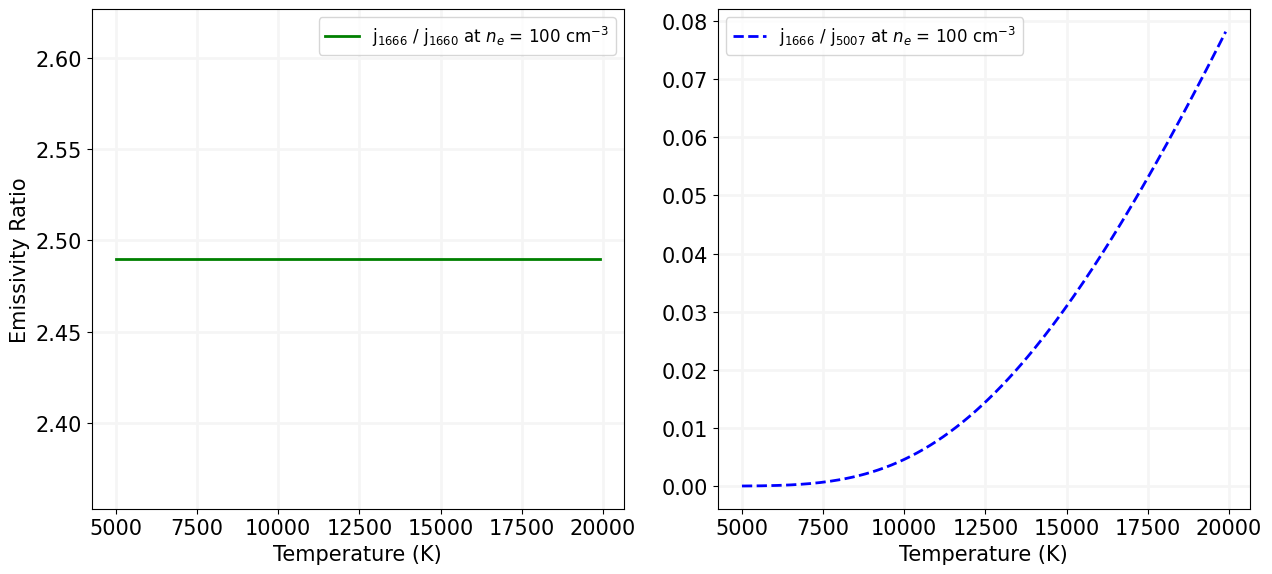

In [12]:
tRang = np.arange(5000,20000,100) # Define a range of temperatures
dRangL= np.arange(1e0,1e3,1e1)
dRangI= np.arange(1e3,1e5,1e2)
dRangH= np.arange(1e5,1e7,1e3)
dRang = np.concatenate((dRangL,dRangI,dRangH)) # Define a range of densities

em1660t = O3.getEmissivity(tRang,1e2,wave=1660.0) # Emissivity as a function of temperature at ne = 100 cm^-3
em1666t = O3.getEmissivity(tRang,1e2,wave=1666.1) # Emissivity as a function of temperature at ne = 100 cm^-3
em5007t = O3.getEmissivity(tRang,1e2,wave=5006.8) # Emissivity as a function of temperature at ne = 100 cm^-3

em1660d = O3.getEmissivity(1e4,dRang,wave=1660.0) # Emissivity as a function of density at Te = 1e4 K
em1666d = O3.getEmissivity(1e4,dRang,wave=1666.1) # Emissivity as a function of density at Te = 1e4 K
em5007d = O3.getEmissivity(1e4,dRang,wave=5006.8) # Emissivity as a function of density at Te = 1e4 K

#==========================================
plt.figure(figsize=(13,6))
fsize = 15

plt.subplot(1,2,1)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.plot(tRang,em1666t/em1660t,c='green',lw=2,label=r'j$_{1666}$ / j$_{1660}$ at $n_e$ = 100 cm$^{-3}$')

plt.xlabel('Temperature (K)',fontsize=fsize)
plt.ylabel('Emissivity Ratio',fontsize=fsize)

plt.legend(fontsize=fsize-3)

#==========================================

plt.subplot(1,2,2)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.plot(tRang,em1666t/em5007t,c='blue',ls='--',lw=2,label=r'j$_{1666}$ / j$_{5007}$ at $n_e$ = 100 cm$^{-3}$')

plt.xlabel('Temperature (K)',fontsize=fsize)
# plt.ylabel('Emissivity Ratio',fontsize=fsize)

plt.legend(fontsize=fsize-3)

plt.tight_layout()

In the left panel, the emissivity ratio [O III]1666/[O III]1660 is constant as a function of $T_e$. This is because the two emission lines originate from the same energy level (the sixth) of the O$^{2+}$ ion such that the emissivity ratio of these two transitions is fixed. In the right panel, the emissivity ratio [O III]1666/[O III]5007 is exponentially sensitive to $T_e$ due to the large difference in energies required to excited these levels (see [O III] Grotrian diagram above). From the prior emissivity plots, if electron density is < 10$^4$ cm$^{-3}$ then the emissivity ratio is roughly independent of $n_e$. As such, the intensity ratio of these two emission lines is directly related to the electron gas temperature.

Similarly, plotting the emissivity ratio of [C III]1907/[C III]1909:

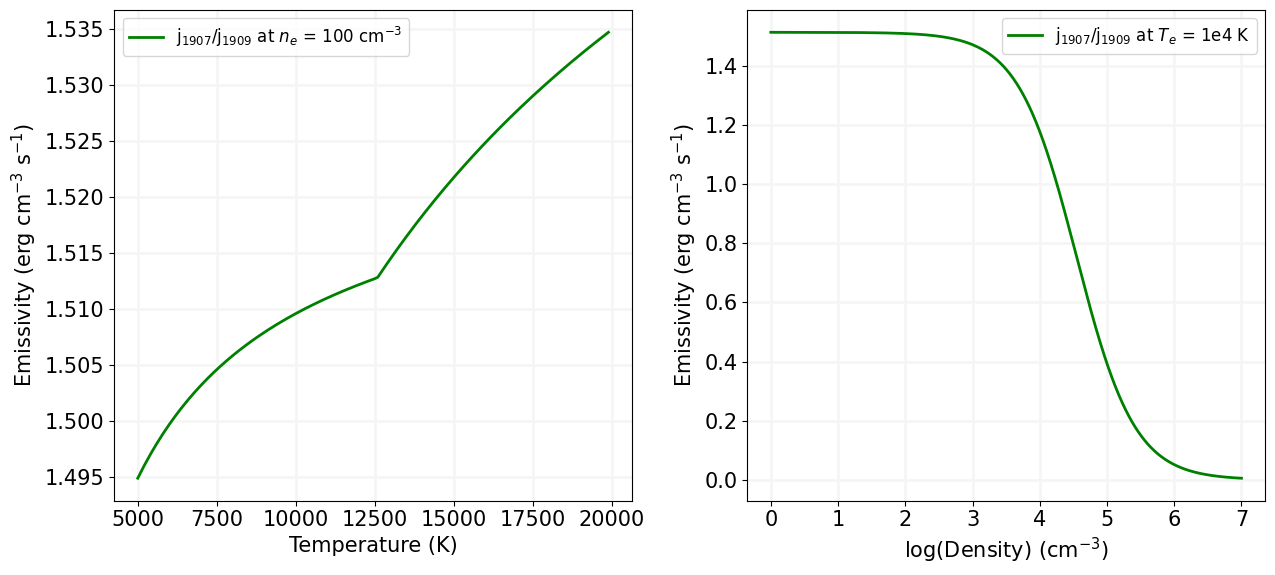

In [13]:
tRang = np.arange(5000,20000,100) # Define a range of temperatures
dRangL= np.arange(1e0,1e3,1e1)
dRangI= np.arange(1e3,1e5,1e2)
dRangH= np.arange(1e5,1e7,1e3)
dRang = np.concatenate((dRangL,dRangI,dRangH)) # Define a range of densities

em1907t = C3.getEmissivity(tRang,1e2,wave=1907) # Emissivity as a function of temperature at ne = 100 cm^-3
em1909t = C3.getEmissivity(tRang,1e2,wave=1909) # Emissivity as a function of temperature at ne = 100 cm^-3
em1907d = C3.getEmissivity(1e4,dRang,wave=1907) # Emissivity as a function of temperature at ne = 100 cm^-3
em1909d = C3.getEmissivity(1e4,dRang,wave=1909) # Emissivity as a function of temperature at ne = 100 cm^-3

#==========================================
plt.figure(figsize=(13,6))
fsize = 15

plt.subplot(1,2,1)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.plot(tRang,em1907t/em1909t,c='green',lw=2,label=r'j$_{1907}$/j$_{1909}$ at $n_e$ = 100 cm$^{-3}$')

plt.xlabel('Temperature (K)',fontsize=fsize)
plt.ylabel('Emissivity (erg cm$^{-3}$ s$^{-1}$)',fontsize=fsize)

plt.legend(fontsize=fsize-3)

#==========================================

plt.subplot(1,2,2)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.plot(np.log10(dRang),em1907d/em1909d,c='green',lw=2,label=r'j$_{1907}$/j$_{1909}$ at $T_e$ = 1e4 K')

plt.xlabel(r'log(Density) (cm$^{-3}$)',fontsize=fsize)
plt.ylabel('Emissivity (erg cm$^{-3}$ s$^{-1}$)',fontsize=fsize)

plt.legend(fontsize=fsize-3)

plt.tight_layout()

The left panel reveals that the emissivity ratio of the two [C III] lines is relatively insensitive to the electron gas temperature. This is due to the similar excitation energy of the levels that produce these transitions (see Grotrian diagram). The right panel shows that this emissivity ratio is very sensitive to $n_e$ due to a difference in the critical densities of the transitions. At densities between 10$^3$ and 10$^6$ cm$^{-3}$, the [C III] emission lines are good tracers of the electron density. Other emission line pairs are sensitive to electron densities where these emission lines are not (e.g., $n_e$ < 10$^3$ cm$^{-3}$).

From these plots, we can immediately see the utility of various emission lines in the UV: with a measure of [C III]1907 and 1909, the intensity ratio can be used to directly measure $n_e$ without knowing the abundance of C$^{+2}$ ions in the gas; similarly, a measurement of [O III]1666 could be used with the optical [O III]5007 line to determine the gas temperature, although it is often easier to use the optical line [O III]4363 to avoid aperture biases from ground- and space-based observatories. With $T_e$ and $n_e$, we can use the emissivity of a given transition and the intensity of that emission line to calculate the ionic abundance within the nebula.

## 3. Measuring Nebular Properties with PyNeb

### 3.1. Example Spectra and Emission Line Fits

To show how PyNeb can measure the above properties, we require emission line fits from high-resolution UV spectra of ionized regions. We will use a select number of galaxies from the CLASSY sample with high S/N emission line measurements: J1044+0353, J1253-0312, J1323-0132, J1418+2102, and J1545+0858. We will read in these emission line fits in the following section; for now, we will start by plotting an example of the CLASSY co-added spectrum of J1323-0132:

In [14]:
#Read in the file from the Spectra Folder
fname = 'SpectraFiles/hlsp_classy_hst_cos_j1323-0132_multi_v1_coadded.fits'
hdu = fits.open(fname)
data = hdu[15].data
wave = np.array([data[i][0] for i in range(len(data))])
flux = np.array([data[i][1] for i in range(len(data))])
err  = np.array([data[i][2] for i in range(len(data))])
hdu.close()

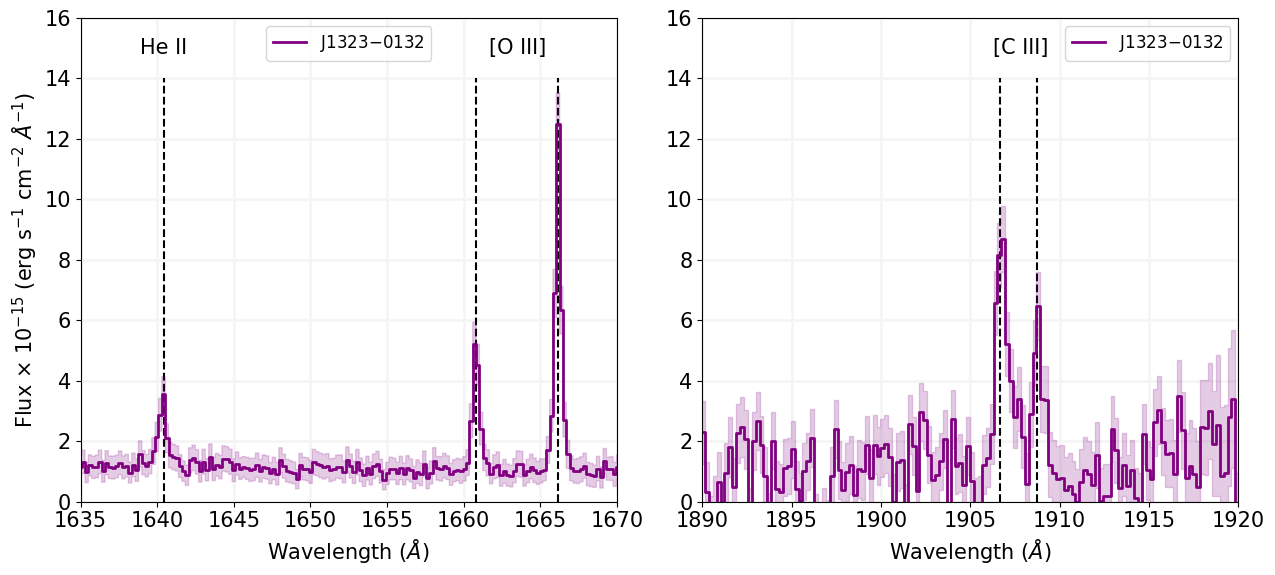

In [15]:
#==========================================
plt.figure(figsize=(13,6))
fsize = 15

plt.subplot(1,2,1)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.vlines([1640.42,1660.81,1666.15],0,14,ls='--',color='k')
plt.fill_between(wave,flux + err,flux - err,color='purple',step='mid',alpha=0.2,zorder=2)
plt.step(wave,flux,c='purple',lw=2,label=r'J1323$-$0132',where='mid')

plt.text(1640.42,15,'He II',ha='center',va='center',fontsize=fsize)
plt.text(1663.5,15,'[O III]',ha='center',va='center',fontsize=fsize)

plt.xlabel(r'Wavelength ($\AA$)',fontsize=fsize)
plt.ylabel(r'Flux $\times$ 10$^{-15}$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)',fontsize=fsize)
plt.xlim(1635,1670)
plt.ylim(0,16)

plt.legend(fontsize=fsize-3,loc=9)

#==========================================
plt.subplot(1,2,2)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.vlines([1906.68,1908.73],0,14,ls='--',color='k')
plt.fill_between(wave,flux + err,flux - err,color='purple',step='mid',alpha=0.2,zorder=2)
plt.step(wave,flux,c='purple',lw=2,label=r'J1323$-$0132',where='mid')

plt.text(1907.8,15,'[C III]',ha='center',va='center',fontsize=fsize)

plt.xlabel(r'Wavelength ($\AA$)',fontsize=fsize)
plt.xlim(1890,1920)
plt.ylim(0,16)

plt.legend(fontsize=fsize-3)

plt.tight_layout()

The spectrum shows the intense emission lines from He II, [O III], and [C III]. If we wanted to obtain the emission line fluxes from the spectra, we can fit a model assuming a linear continuum with Gaussian emission lines. We can use minimize the $\chi^2$ using scipy.optimize, an example of these functions are provided below:

In [16]:
def model_Gaussian(x,x0,fwhm,a):
    """
    Accept the position x, the center of the Gaussian x0, the flux a, and the FWHM. Return
    the value of the Gaussian defined by these parameters at all positions in x.
    """
    
    #Convert FWHM to standard deviation
    s = fwhm/(2*np.sqrt(2*np.log(2)))
    
    return (a/np.sqrt(2*m.pi*np.power(s,2))) * np.exp(-0.5*np.power(x-x0,2)/np.power(s,2))

def line_fitting_model(wave,centers,model_input):
    """
    Fit the UV continuum assuming a model involving a linear continuum and multiple Gaussian.
    model_input[0] = constant central wavelength shift, model_input[1] = FWHM,
    model_input[2+i] = flux of line i.
    """
    
    numLines = len(centers)
    
    #No Linear Continuum, assume it's already taken out
    fit = 0*wave
    
    #Narrow, Assume same GFWHM
    for i in range(numLines):
        fit+= model_Gaussian(wave,model_input[1+2*i],model_input[0],model_input[2+2*i])

    return fit

def full_likelihood(model_input,wave,flux,errs,centers):
    """
    Chi squared assuming Gaussian distribution of measurements: sum of residuals^2/error^2
    """
    
    return np.sum((flux - line_fitting_model(wave,centers,model_input))**2./errs**2.)

def lineFitter(wave,flux,errs,centers,good,goodL):
    """
    General program to fit a set of emission lines in the spectrum provided.
    wave, flux, and errs are the arrays of these values.
    centers= array of line centers to fit
    good   = full range of the spectrum to consider for fitting
    goodL  = range to consider for linear fitting
    """
    waveG, waveL = wave[good], wave[goodL]
    fluxG, fluxL = flux[good], flux[goodL]
    errsG, errsL = errs[good], errs[goodL]
    
    linFit  = np.polyfit(waveL,fluxL,1)
    slope, intercept = linFit[0], linFit[1]
    
    fluxG_sub = fluxG - (intercept + slope*waveG)
    
    numLines = len(centers)
    
    #Gaussian Fitting Model w/ no continuum
    pTest = [3]
    bndsA = [(0.3,4)]
    for i in range(numLines):
        #Center for Gaussian emission lines
        pTest.append(centers[i])
        bndsA.append((centers[i]-0.5,centers[i]+0.5))
        #Flux for all Gaussian lines, consider only positive fluxes
        pTest.append(1)
        bndsA.append((0,np.inf))
        
    #Fit
    gaussfit = optimize.minimize(full_likelihood,pTest,args=(waveG,fluxG_sub,errsG,centers),bounds=bndsA)
    results = gaussfit.x
    
    return np.concatenate((results,linFit))

With the above functions defined, we can fit the emission lines from J1323-0132 plotted above:

In [17]:
#Define areas to fit and areas of continuum for each line:
goodHe2, goodHe2L = (wave > 1635) & (wave < 1645), ((wave > 1635) & (wave < 1638)) | ((wave > 1642) & (wave < 1645))
goodO3,  goodO3L  = (wave > 1655) & (wave < 1670), ((wave > 1655) & (wave < 1658.5)) | ((wave > 1662.5) & (wave < 1665)) | ((wave > 1667.5) & (wave < 1670))
goodC3,  goodC3L  = (wave > 1902.5) & (wave < 1915), ((wave > 1902.5) & (wave < 1905)) | ((wave > 1910) & (wave < 1915))

#Define line centers:
he2_centers, o3_centers, c3_centers = [1640.42], [1660.81,1666.15], [1906.68,1908.73]

#Run the functions to solve for the emission line fluxes:
he2_results = lineFitter(wave,flux,err,he2_centers,goodHe2,goodHe2L)
o3_results  = lineFitter(wave,flux,err,o3_centers,goodO3,goodO3L)
c3_results  = lineFitter(wave,flux,err,c3_centers,goodC3,goodC3L)

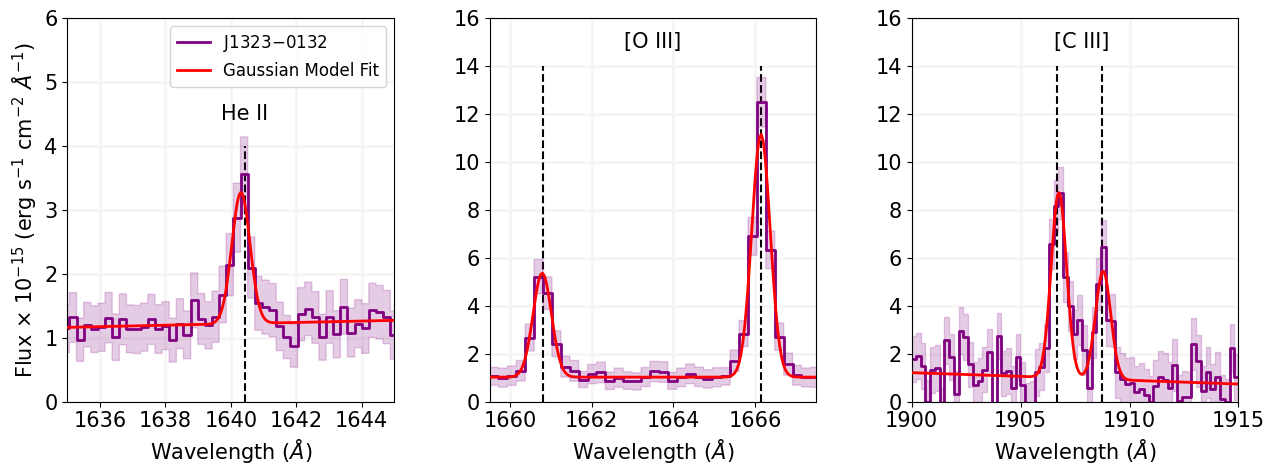

In [18]:
#Plot results
x = np.arange(1500,2000,0.05)
#==========================================
plt.figure(figsize=(13,5))
fsize = 15

plt.subplot(1,3,1)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.vlines([1640.42],0,4,ls='--',color='k')
plt.fill_between(wave,flux + err,flux - err,color='purple',step='mid',alpha=0.2,zorder=2)
plt.step(wave,flux,c='purple',lw=2,label=r'J1323$-$0132',where='mid')

plt.plot(x,he2_results[-1] + x*he2_results[-2] + line_fitting_model(x,he2_centers,he2_results[:-2]),color='red',ls='-',
         lw=2,zorder=4,label='Gaussian Model Fit')

plt.text(1640.42,4.5,'He II',ha='center',va='center',fontsize=fsize)

plt.xlabel(r'Wavelength ($\AA$)',fontsize=fsize)
plt.ylabel(r'Flux $\times$ 10$^{-15}$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)',fontsize=fsize)
plt.xlim(1635,1645)
plt.ylim(0,6)

plt.legend(fontsize=fsize-3)

#==========================================
plt.subplot(1,3,2)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.vlines([1640.42,1660.81,1666.15],0,14,ls='--',color='k')
plt.fill_between(wave,flux + err,flux - err,color='purple',step='mid',alpha=0.2,zorder=2)
plt.step(wave,flux,c='purple',lw=2,label=r'J1323$-$0132',where='mid')

plt.plot(x,o3_results[-1] + x*o3_results[-2] + line_fitting_model(x,o3_centers,o3_results[:-2]),color='red',ls='-',
         lw=2,zorder=4,label='Gaussian Model Fit')

plt.text(1663.5,15,'[O III]',ha='center',va='center',fontsize=fsize)

plt.xlabel(r'Wavelength ($\AA$)',fontsize=fsize)
plt.xlim(1659.5,1667.5)
plt.ylim(0,16)

#==========================================
plt.subplot(1,3,3)
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.vlines([1906.68,1908.73],0,14,ls='--',color='k')
plt.fill_between(wave,flux + err,flux - err,color='purple',step='mid',alpha=0.2,zorder=2)
plt.step(wave,flux,c='purple',lw=2,label=r'J1323$-$0132',where='mid')

plt.plot(x,c3_results[-1] + x*c3_results[-2] + line_fitting_model(x,c3_centers,c3_results[:-2]),color='red',ls='-',
         lw=2,zorder=4,label='Gaussian Model Fit')

plt.text(1907.8,15,'[C III]',ha='center',va='center',fontsize=fsize)

plt.xlabel(r'Wavelength ($\AA$)',fontsize=fsize)
plt.xlim(1900,1915)
plt.ylim(0,16)

plt.tight_layout()

A simple Gaussian+Linear continuum model might not be sufficient for some of the UV emission lines, particularly those near stellar absorption features. For now, we can save the simple emission line fluxes in their own arrays to use in the next section:

In [19]:
j1323_waves  = np.array([he2_results[1],o3_results[1],o3_results[3],c3_results[1],c3_results[3]])
j1323_fluxes = np.array([he2_results[2],o3_results[2],o3_results[4],c3_results[2],c3_results[4]])

### 3.2 Reddening Corrections with the redCorr Class

The fits above must be corrected for dust attenuation before we can measure the nebular properties. Performing reddening corrections in PyNeb is possible through the reddCorr class. To initialize this class:

In [20]:
#Initialize
rc = pn.RedCorr()

rc will perform the reddening correction for a given reddening law and wavelength. Numerous reddening laws are defined in PyNeb. For example:

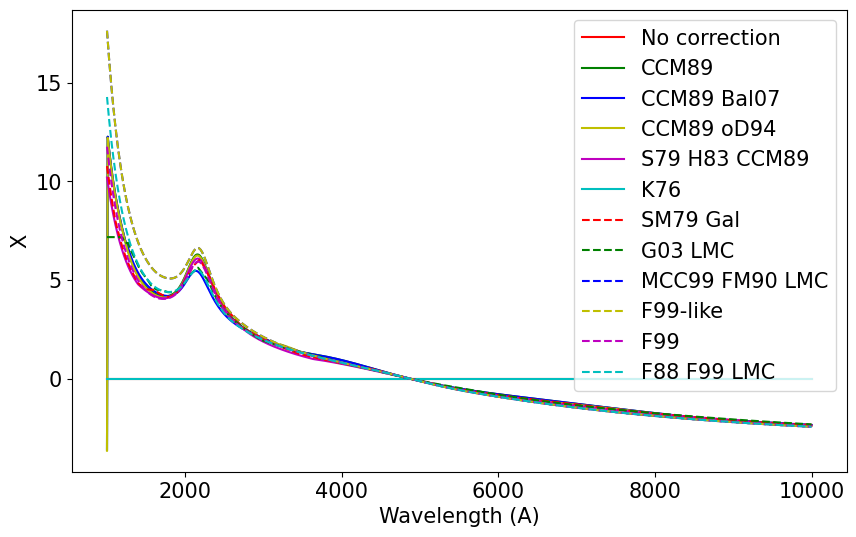

In [21]:
f, ax1 = plt.subplots(figsize=(10,6))
rc.plot(laws = 'all', ax=ax1)

In this plot, X as a function of wavelength is X($\lambda$)=A($\lambda$)/E(B-V) where A($\lambda$) is the reddening law selected. Suppose we want to correct for Galactic extinction using the Cardelli+1989 reddening law with R$_V$ of 3.1. We do so by defining the properties stored in rc.

In [22]:
#Specify Law and Parameters
rc.law = 'CCM89'
rc.R_V = 3.1

Using the magnitude of Galactic extinction, we now have all the information needed to reddening correct the emission line fluxes. The getCorr function takes the wavelength (either an individual wavelength or a wavelength array) and returns the factor to be applied to the spectrum to correct for reddening. One can also define a wavelength to perform the reddening corrections relative to; this is useful if one is concerned about emission line intensity ratios. Some examples are provided below for different E(B-V):

In [23]:
#Define E(B-V)
rc.E_BV = 0.10

#Print a few examples
common_uv_corr1 = rc.getCorr(np.array([1640,1660.8,1666.1,1906.7,1908.7]))
print('Cardelli+1989 Reddening Correction for E(B-V)=0.10 at 1640, 1660, 1666, 1907, and 1909:')
print(common_uv_corr1)
print()

#Change E(B-V) and repeat:
rc.E_BV = 0.30
common_uv_corr2 = rc.getCorr(np.array([1640,1660.8,1666.1,1906.7,1908.7]))
print('Cardelli+1989 Reddening Correction for E(B-V)=0.30 at 1640, 1660, 1666, 1907, and 1909:')
print(common_uv_corr2)
print()

#To Perform Relative Corrections:
rel_common_uv_corr2 = rc.getCorr(np.array([1640,1660.8,1666.1,1906.7,1908.7]),1666.1)
print('Cardelli+1989 Reddening Correction for E(B-V)=0.30 relative to 1666 at 1640, 1660, 1666, 1907, and 1909:')
print(rel_common_uv_corr2)

Cardelli+1989 Reddening Correction for E(B-V)=0.10 at 1640, 1660, 1666, 1907, and 1909:
[2.06199033 2.05601738 2.05471088 2.11660871 2.11862513]

Cardelli+1989 Reddening Correction for E(B-V)=0.30 at 1640, 1660, 1666, 1907, and 1909:
[8.76717897 8.69121198 8.67465397 9.48247562 9.50960237]

Cardelli+1989 Reddening Correction for E(B-V)=0.30 relative to 1666 at 1640, 1660, 1666, 1907, and 1909:
[1.01066613 1.00190878 1.         1.09312437 1.09625149]


While many reddening laws are stored in PyNeb, it is sometimes necessary to define your own reddening law. A user-defined reddening law can be passed into the redCorr class and used in reddening corrections. As an example, we can construct the Reddy+2016 reddening law as a function and apply it:

In [24]:
def Reddy16(wave,params):
    """
    Eq 3 from Reddy+2016. Implementation in PyNeb requires a wavelength dependence (wave) and 
    a parameter input (params).
    """
    
    return 2.191 + 0.974/(wave/1e4)

In [25]:
#Initialize
rc = pn.RedCorr()

#Specify Law and Parameters
rc.UserFunction = Reddy16
rc.law='user'

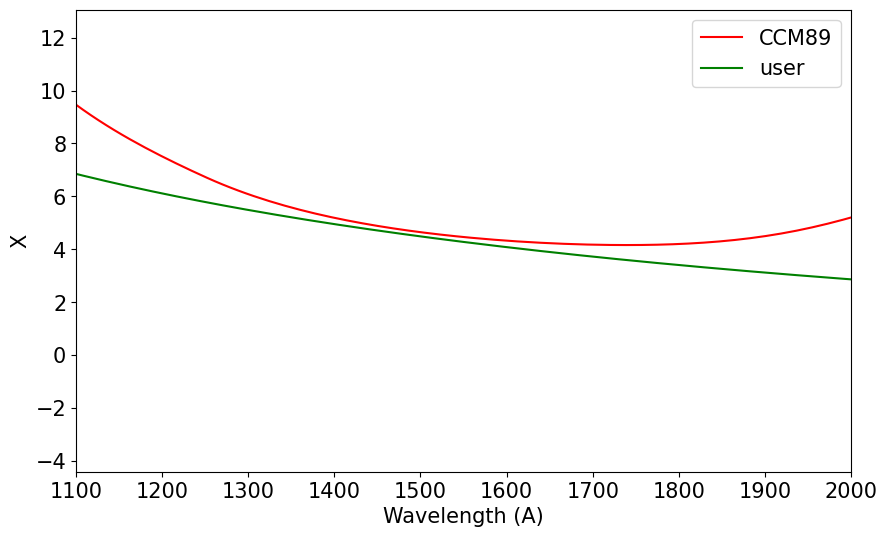

In [26]:
f, ax1 = plt.subplots(figsize=(10,6))
ax1.set_xlim(1100,2000)
rc.plot(laws = ['CCM89','user'], ax=ax1)

In [27]:
#Perform corrections with user-defined reddening law:
rc.E_BV = 0.30

#Change E(B-V) and repeat:
common_uv_corr2 = rc.getCorr(np.array([1640,1660.8,1666.1,1906.7,1908.7]))
print('Reddy+2016 Reddening Correction for E(B-V)=0.30 at 1640, 1660, 1666, 1907, and 1909:')
print(common_uv_corr2)
print()

#To Perform Relative Corrections:
rel_common_uv_corr2 = rc.getCorr(np.array([1640,1660.8,1666.1,1906.7,1908.7]),1666.1)
print('Reddy+2016 Reddening Correction for E(B-V)=0.30 relative to 1666 at 1640, 1660, 1666, 1907, and 1909:')
print(rel_common_uv_corr2)

Reddy+2016 Reddening Correction for E(B-V)=0.30 at 1640, 1660, 1666, 1907, and 1909:
[9.45372417 9.26141245 9.21379438 7.51478009 7.50367401]

Reddy+2016 Reddening Correction for E(B-V)=0.30 relative to 1666 at 1640, 1660, 1666, 1907, and 1909:
[1.02604028 1.00516813 1.         0.81560102 0.81439564]


We can use getCorr and multiply the flux of the emission lines to obtain the reddening-corrected emission line intensities. As an example, we can reddening correct the emission line fluxes we fit in J1323-0132 using the Reddy+2016 law and E(B-V)=0.128+/-0.042 (measured from the optical Balmer decrement):

In [28]:
#Initialize
rc = pn.RedCorr()

#Specify Law and Parameters
rc.UserFunction = Reddy16
rc.law='user'

rc.E_BV = 0.128

#Obtain intensities:
j1323_inten = j1323_fluxes*rc.getCorr(j1323_waves)

Finally, we can account for the uncertainty in the reddening using the getErrCorr function. For a provided reddening law, this function will return the uncertainty in the reddening correction at a given wavelength and for a given error on E(B-V). Similar to getCorr, it can also take a wavelength to perform the calculations relative to:

In [29]:
#Obtain intensity uncertainty (note, this does not account for uncertainty on the emission line fluxes):
j1323_intenE = j1323_fluxes*rc.getErrCorr(j1323_waves,0.042)

for i in range(len(j1323_inten)):
    print('Intensity of emission line at %5.2f: %3.2f +/- %3.2f' % (j1323_waves[i],j1323_inten[i],j1323_intenE[i]))

Intensity of emission line at 1640.31: 3.74 +/- 0.06
Intensity of emission line at 1660.79: 6.35 +/- 0.10
Intensity of emission line at 1666.15: 14.77 +/- 0.23
Intensity of emission line at 1906.76: 16.05 +/- 0.25
Intensity of emission line at 1908.79: 9.37 +/- 0.14


### Read in CLASSY Intensities:

For simplicity we will use the CLASSY emission line intensities from Mingozzi+2022. These fits are homogeneous and account for the UV stellar continuum and broad components in some of the emission lines:

In [30]:
cfname = 'SpectraFiles/CLASSY_Select_UV_Intensities.dat'
c_Names = np.loadtxt(cfname,unpack=True,usecols=(0),dtype=str)
c_1660i, c_1660el, c_1660eu, c_1660SN = np.nan_to_num(np.loadtxt(cfname,unpack=True,usecols=(-28,-27,-26,-25)))
c_1666i, c_1666el, c_1666eu, c_1666SN = np.nan_to_num(np.loadtxt(cfname,unpack=True,usecols=(-24,-23,-22,-21)))
c_1907i, c_1907el, c_1907eu, c_1907SN = np.nan_to_num(np.loadtxt(cfname,unpack=True,usecols=(-8,-7,-6,-5)))
c_1909i, c_1909el, c_1909eu, c_1909SN = np.nan_to_num(np.loadtxt(cfname,unpack=True,usecols=(-4,-3,-2,-1)))

Here, the name of each galaxy is stored in c_Names. The reddening-corrected (both foreground and within each galaxy) emission line intensities, lower and upper errors, and S/N are stored in their own numpy arrays, which enable easier manipulation by PyNeb. np.nan_to_num is used to set the flux and uncertainty of any undetected emission line to 0. Some of the following analysis will rely on the optical emission line intensities, which are read in as well:

In [31]:
ofname = 'SpectraFiles/CLASSY_Select_Optical_Intensities.dat'
c_3727i, c_3727e = np.nan_to_num(np.loadtxt(ofname,unpack=True,usecols=(1,2)))
c_4363i, c_4363e = np.nan_to_num(np.loadtxt(ofname,unpack=True,usecols=(3,4)))
c_5007i, c_5007e = np.nan_to_num(np.loadtxt(ofname,unpack=True,usecols=(5,6)))
c_6717i, c_6717e = np.nan_to_num(np.loadtxt(ofname,unpack=True,usecols=(7,8)))
c_6731i, c_6731e = np.nan_to_num(np.loadtxt(ofname,unpack=True,usecols=(9,10)))

Again, each numpy array corresponds to an emission line intensity and its uncertainty.

### 3.3 Electron Temperatures and Densities with getTemDen

Once reddening correction is complete, we are now ready to measure $T_e$ and $n_e$ from the emission lines. $T_e$ measurements from a UV spectrum are challenging owing to a lack of emission lines from different energy levels of, for example, [O III], [C III], etc. Instead, $T_e$ is often measured in the optical using auroral and nebular line pairs such as [O III] 4363 and 5007, [S III] 6312 and 9532, and [N II] 5755 and 6584. With broad wavelength coverage, one can use the [O III] 1666 as an auroral line to directly measure $T_e$ instead of [O III] 4363.

The PyNeb getTemDen function allows for the calculation of either $T_e$ or $n_e$. This function is part of the Atom class and requires the following to calculate $T_e$ ($n_e$): for $n_e$ ($T_e$), the emission line ratio, and the emission lines being used. Because of the weak density dependence on the [O III] line emissivities in the low density limit, it is often the case that $T_e$ is calculated at $n_e$ = 100 cm$^{-3}$. For example:

In [32]:
#[O III] 4363/5007 ratio measured for J1044+0353:
j1044_O3rat= c_4363i[0]/c_5007i[0]
# wave1 = numerator, wave2 = denominator
j1044_teO3 = O3.getTemDen(j1044_O3rat,den=1e2,wave1=4363,wave2=5007)
print('Temperature of ' + c_Names[0] + ' from [O III]: %5.1f K' % j1044_teO3)
print()
#Another method is to use "to_eval", which allows one to include multiple lines in the ratio. This is useful for blended lines:
j1044_teO3 = O3.getTemDen(j1044_O3rat,den=1e2,to_eval='L(4363) / L(5007)')
print('Repeat for ' + c_Names[0] + ': %5.1f K' % j1044_teO3)
print()

#Can also run on an array of ratios:
classy_teO3 =  O3.getTemDen(c_4363i/c_5007i,den=1e2,wave1=4363,wave2=5007)
for i in range(len(classy_teO3)):
    print('Temperature of ' + c_Names[i] + ' from [O III]: %5.1f K' % classy_teO3[i])

Temperature of J1044+0353 from [O III]: 19102.5 K

Repeat for J1044+0353: 19102.5 K

Temperature of J1044+0353 from [O III]: 19102.5 K
Temperature of J1253-0312 from [O III]: 13327.0 K
Temperature of J1323-0132 from [O III]: 17721.8 K
Temperature of J1418+2102 from [O III]: 17696.4 K
Temperature of J1545+0858 from [O III]: 15967.0 K


To measure the electron density, we employ the UV [C III] lines discussed above. This density calculation takes the electron temperature as an input, requiring a measure of $T_e$ in the gas that contains C$^{2+}$ ions. Given the similar ionization potentials of C$^{+}$ and O$^{+}$, and that a direct measure of T$_e$[C III] is not possible, T$_e$[O III] acts as a good substitute. Using the CLASSY line fits:

In [33]:
#[C III] 1907/1909 ratio measured for J1044+0353:
j1044_C3rat = c_1907i[0]/c_1909i[0]
j1044_neC3 = C3.getTemDen(j1044_C3rat,tem=j1044_teO3,wave1=1907,wave2=1909)
print('ne of ' + c_Names[0] + ' from UV [C III]: %4.1f cm^-3' % j1044_neC3)
print()

#Can also run on an array of ratios using an array of temperatures:
classy_neC3 = C3.getTemDen(c_1907i/c_1909i,tem=classy_teO3,wave1=1907,wave2=1909)
for i in range(len(classy_neC3)):
    print('ne of ' + c_Names[i] + ' from UV [C III]: %4.1f cm^-3' % classy_neC3[i])

ne of J1044+0353 from UV [C III]: 6387.4 cm^-3

ne of J1044+0353 from UV [C III]: 6387.4 cm^-3
ne of J1253-0312 from UV [C III]: 6724.0 cm^-3
ne of J1323-0132 from UV [C III]:  nan cm^-3
ne of J1418+2102 from UV [C III]: 5127.1 cm^-3
ne of J1545+0858 from UV [C III]: 11785.4 cm^-3


Notice that the third galaxy, J1323-0132, has a "NaN" density. This is because the [C III] ratio, ~1.55, is consistent with the theoretical emissivity ratio as $n_e$ approaches very small densities. As shown early, the emissivity ratio of the [C III] emission lines is most sensitive to densities between 10$^3$ and 10$^6$ cm$^{-3}$; at low electron densities, these emission lines will approach their theoretical ratio. Luckily, other emission line ratios can be used to measure $n_e$ in low-density nebulae. The most commonly-used pair in the optical is [S II] 6717 and [S II] 6737, which is sensitive to densities below ~10$^{3}$. For the CLASSY galaxies:

In [34]:
#[S II] 6717/6731 ratio measured for J1044+0353:
j1044_S2rat = c_6717i[0]/c_6731i[0]
j1044_neS2 = S2.getTemDen(j1044_S2rat,tem=j1044_teO3,wave1=6717,wave2=6731)
print('ne of ' + c_Names[0] + ' from Optical [S II]: %4.1f cm^-3' % j1044_neS2)
print()

#Can also run on an array of ratios using an array of temperatures:
classy_neS2 = S2.getTemDen(c_6717i/c_6731i,tem=classy_teO3,wave1=6717,wave2=6731)
for i in range(len(classy_neS2)):
    print('ne of ' + c_Names[i] + ' from Optical [S II]: %4.1f cm^-3' % classy_neS2[i])

ne of J1044+0353 from Optical [S II]: 209.9 cm^-3

ne of J1044+0353 from Optical [S II]: 209.9 cm^-3
ne of J1253-0312 from Optical [S II]: 1252.5 cm^-3
ne of J1323-0132 from Optical [S II]: 348.4 cm^-3
ne of J1418+2102 from Optical [S II]: 65.6 cm^-3
ne of J1545+0858 from Optical [S II]: 135.9 cm^-3


#### 3.3.1 Estimating Uncertainties with MCMC and getTemDen

getTemDen is very useful for quickly measuring the gas-phase properties within a nebula, but it does not provide a measure of the uncertainty on these properties. For example, uncertainties associated with $T_e$, $n_e$, and the line intensity ratio will all produce slight variations in the physical conditions. The most common method used to obtain uncertainties on $T_e$ or $n_e$ is to employ an MCMC approach.

First, we can generate a sample of line ratios using a normal distribution centered on the measured line ratio and with standard deviation equal to the uncertainty on the line ratio. This is used in getTemDen to determine the resulting distribution of $T_e$ or $n_e$. The standard deviation of the $T_e$/$n_e$ distribution is a good approximation for the uncertainty on the quantity. For $T_e$[O III] measured in J1044+0353:

Temperature of J1044+0353 from [O III]: 19102.5 +/- 216.0 K


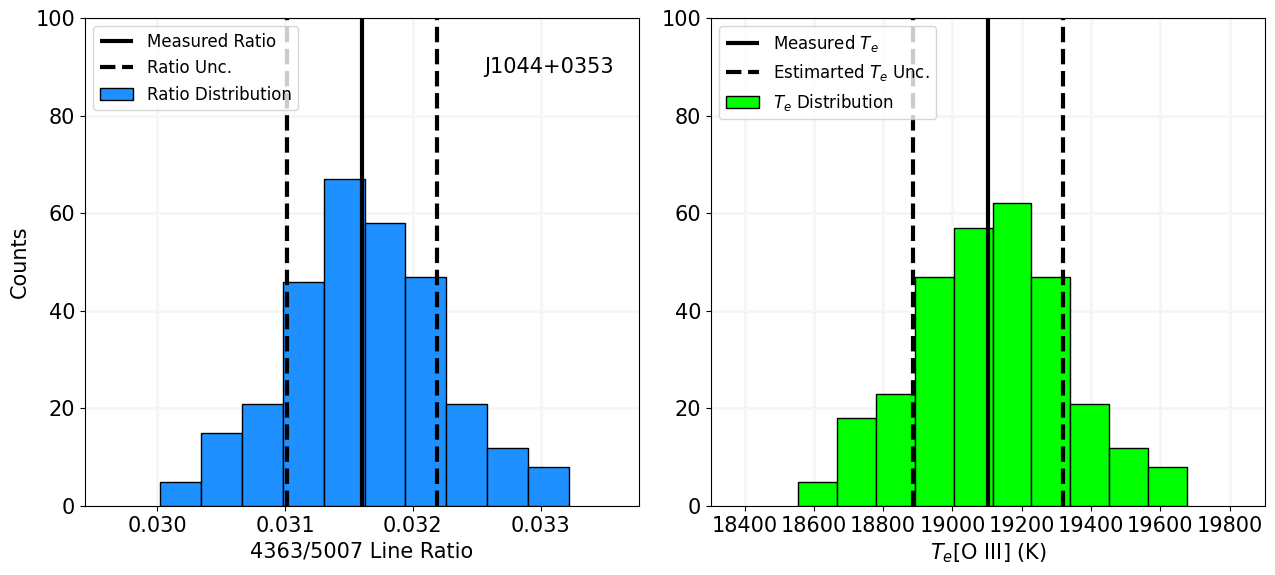

In [35]:
#Define J1044+0353's line ratio and its uncertainty
j1044_O3rat  = c_4363i[0]/c_5007i[0]
j1044_O3ratE = j1044_O3rat*np.sqrt(np.power(c_4363e[0]/c_4363i[0],2) + np.power(c_5007e[0]/c_5007i[0],2))

#Generate a distribution of 300 line ratios
dist = random.normal(j1044_O3rat,j1044_O3ratE,300)

#Determine Te from the measured line ratio and the distribution
j1044_teO3 = O3.getTemDen(j1044_O3rat,den=1e2,wave1=4363,wave2=5007)
teO3_dist  = O3.getTemDen(dist,den=1e2,wave1=4363,wave2=5007)

#Determine standard deviation, removing any NaN temperatures
j1044_teO3E= np.std(teO3_dist[(np.nan_to_num(teO3_dist) > 0.)])

#Print Results
print('Temperature of ' + c_Names[0] + ' from [O III]: %5.1f +/- %3.1f K' % (j1044_teO3,j1044_teO3E))

#==========================================
plt.figure(figsize=(13,6))
fsize = 15

plt.subplot(1,2,1)
plt.axis([j1044_O3rat-3.7*j1044_O3ratE,j1044_O3rat+3.7*j1044_O3ratE,0,100])
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.vlines([j1044_O3rat],0,350,lw=3,ls='-',color='k',zorder=4,label='Measured Ratio')
plt.vlines([j1044_O3rat-j1044_O3ratE,j1044_O3rat+j1044_O3ratE],0,350,lw=3,ls='--',color='k',zorder=4,label='Ratio Unc.')
plt.hist(dist,color='dodgerblue',zorder=3,edgecolor='k',align='mid',label=r'Ratio Distribution')

plt.xlabel(r'4363/5007 Line Ratio',fontsize=fsize)
plt.ylabel(r'Counts',fontsize=fsize)
plt.text(j1044_O3rat+2.5*j1044_O3ratE,90,c_Names[0],fontsize=fsize,ha='center',va='center')

plt.legend(fontsize=fsize-3,loc=2)

#==========================================
plt.subplot(1,2,2)
plt.axis([j1044_teO3-3.7*j1044_teO3E,j1044_teO3+3.7*j1044_teO3E,0,100])
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.vlines([j1044_teO3],0,350,lw=3,ls='-',color='k',zorder=4,label=r'Measured $T_e$')
plt.vlines([j1044_teO3-j1044_teO3E,j1044_teO3+j1044_teO3E],0,350,lw=3,ls='--',color='k',zorder=4,label=r'Estimarted $T_e$ Unc.')
plt.hist(teO3_dist,color='lime',zorder=3,edgecolor='k',align='mid',label=r'$T_e$ Distribution')

plt.xlabel(r'$T_e$[O III] (K)',fontsize=fsize)

plt.legend(fontsize=fsize-3,loc=2)

plt.tight_layout()

In general, the same approach can be taken for the [C III] emission lines and the electron density uncertainty. However, there are a few risks associated with this. First, the uncertainty on the UV line ratio can be relatively large. This means that the distribution of ratios can sample a large range, even extending to negative ratios which must be removed before running getTemDen. Second, a randonly drawn ratio could be outside the theoretical range permitted by the line emissivities (see plots above). When this happens, PyNeb will return "NaN" for the density instead of a density < 0. This produces an asymmetric $n_e$ distribution such that the standard deviation is no longer a good estimator of the $n_e$ uncertainty.

Instead, we can use the measured line ratio uncertainty to estimate the upper/lower limits on $n_e$[C III] recognizing that $n_e$ must be greater than zero. For example:

In [36]:
#Define J1044+0353's line ratio and its uncertainty, assuming that symmetric uncertainties
j1044_C3rat  = c_1907i[0]/c_1909i[0]
c3_1907e = (c_1907el[0] + c_1907eu[0])/2
c3_1909e = (c_1909el[0] + c_1909eu[0])/2
j1044_C3ratE = j1044_C3rat*np.sqrt(np.power(c3_1907e/c_1907i[0],2) + np.power(c3_1909e/c_1909i[0],2))

#Calculate ne at the measured line ratio and the upper/lower limits
j1044_neC3  = C3.getTemDen(j1044_C3rat,tem=j1044_teO3,wave1=1907,wave2=1909)
j1044_neC3l = np.nan_to_num(C3.getTemDen(j1044_C3rat+j1044_C3ratE,tem=j1044_teO3,wave1=1907,wave2=1909))
j1044_neC3u = np.nan_to_num(C3.getTemDen(j1044_C3rat-j1044_C3ratE,tem=j1044_teO3,wave1=1907,wave2=1909))

#Print Results
print('[C III] Line Ratio: %3.2f +/- %3.2f' % (j1044_C3rat,j1044_C3ratE))
print('ne of ' + c_Names[0] + ' from UV [C III]: %4.1f +%4.1f -%4.1f cm^-3' % (j1044_neC3,j1044_neC3u-j1044_neC3,j1044_neC3-j1044_neC3l))

[C III] Line Ratio: 1.34 +/- 0.44
ne of J1044+0353 from UV [C III]: 6387.4 +24345.1 -6387.4 cm^-3


### 3.4 Ionic Abundances with getIonAbundance and getEmissivity

With $T_e$, $n_e$, and the intensity of the UV emission lines, we are now in a position to measure the ionic abundance of numerous heavy elements in the gaseous nebula. From the definition of the line intensity, the abundance can be solved for via:

N$_{X^{+i}}$ = I$_\lambda$ / j$_\lambda$

Usually, ionic abundances are calculated relative to the another ion. In the optical, abundances are reported relative to H$^+$ such that the abundance of an ion X$^{+i}$ is

N$_{X^{+i}}$/N$_{H^+}$ = (I$_\lambda$ / I$_{H\beta}$) $\times$ (j$_{H\beta}$ / j$_\lambda$).

The PyNeb Atom class contains a built in function, getIonAbundance, that performs the above calculation. It takes a line intensity ratio (relative to H$\beta$), $T_e$, and $n_e$ as input and returns N$_{X^{+i}}$/N$_{H^+}$. Using the optical line ratios for [O III] 5007 (which are saved relative to HB), we can calculate the ionic abundance of O$^{+2}$. One important note: the ratio assumed in getIonAbundance is relative to HB times 100; i.e., if I(5007) = I(HB), then the input ratio is 100. The assumed ratio can be changed via different parameters in getIonAbundance. This is currently how the emission line intensities are stored in the CLASSY_Selected_Optical_Intensities file.

In [37]:
#getIonAbundance example for J1044+0353 using the previously-calculated temperatures:
print('(I(5007)/I(HB))*100 for J1044+0353: %4.1f +/- %4.1f' % (c_5007i[0],c_5007e[0]))
j1044_opp = O3.getIonAbundance(c_5007i[0],j1044_teO3,1e2,wave=5007)
print('O++/H+ for J1044+0353: %4.3e' % j1044_opp)
print()

#getIonAbundance for the 5 CLASSY galaxies and their [O III] temperatures:
classy_Opp =  O3.getIonAbundance(c_5007i,classy_teO3,[1e2 for i in range(len(classy_teO3))],wave=5007)
for i in range(len(classy_Opp)):
    print('O++/H+ of ' + c_Names[i] + ' from Te[O III]: %4.3e' % classy_Opp[i])

(I(5007)/I(HB))*100 for J1044+0353: 427.5 +/-  4.3
O++/H+ for J1044+0353: 2.684e-05

O++/H+ of J1044+0353 from Te[O III]: 2.684e-05
O++/H+ of J1253-0312 from Te[O III]: 9.742e-05
O++/H+ of J1323-0132 from Te[O III]: 5.384e-05
O++/H+ of J1418+2102 from Te[O III]: 3.712e-05
O++/H+ of J1545+0858 from Te[O III]: 5.392e-05


We can also explicitly calculate the abundance of a given ion using the emission line intensities and getEmissivity to obtain the emissivities of the transition of interest and H$\beta$:

In [38]:
#Calculate the O++/H+ Abundance fot J1044+0353 explicitly:
j1044_emis_ratio = O3.getEmissivity(j1044_teO3,1e2,wave=5007)/H1.getEmissivity(j1044_teO3,1e2,wave=4861)
print('O++/H+ for J1044+0353: %4.3e' % ((c_5007i[0]/100)/j1044_emis_ratio))

O++/H+ for J1044+0353: 2.684e-05


For the CLASSY galaxies, we can use the [O II]3727 optical emission lines to calculate the O+ abundance. However, we need a $T_e$ that describes the low-ionization gas when calculating the emissivity. We can apply a $T_e$-$T_e$ relation to estimate the low-ionization zone temperature from the measured $T_e$[O III]. One example is the [N II]-[O III] relation from Rogers+2021, but this relation does not extend to the high temperatures observed in the low-metallicity CLASSY galaxies. Instead, we can apply the photoionization model relation from Garnett 1992:

$T_e$[O II] = 0.7$\times$$T_e$[O III] + 3000 K

Finally, the [O II]3727 line is a blend of [O II]3726 and [O II]3729. When calculating ionic abundances, we need to use the sum of both emission lines:

In [39]:
#Determine low-ionization zone temperatures:
classy_teO2 = 0.7*classy_teO3 + 3000

#Calculate O+/H+ ionic abundances, must use to_eval for blended 3727 line:
classy_Op = O2.getIonAbundance(c_3727i,classy_teO2,[1e2 for i in range(len(classy_teO2))],to_eval='L(3726)+L(3729)')

for i in range(len(classy_Op)):
    print('O+/H+ of ' + c_Names[i] + ' from Inferred Te[O II]: %4.3e' % classy_Op[i])

O+/H+ of J1044+0353 from Inferred Te[O II]: 1.682e-06
O+/H+ of J1253-0312 from Inferred Te[O II]: 1.257e-05
O+/H+ of J1323-0132 from Inferred Te[O II]: 1.434e-06
O+/H+ of J1418+2102 from Inferred Te[O II]: 3.775e-06
O+/H+ of J1545+0858 from Inferred Te[O II]: 1.937e-06


Unfortunately, getIonAbundance is not as useful in the UV when an H$\beta$ intensity measurement is unavailable. Therefore, we must take the above approach and explicitly define the generic ionic abundance equation using the getEmissivity function.

From the strong lines of [C III] and [O III], we can measure the C$^{2+}$/O$^{2+}$ ionic abundance from

N$_{C^{2+}}$/N$_{O^{2+}}$ = (I$_{1907}$ / I$_{1666}$) $\times$ (j$_{1666}$ / j$_{1907}$)

In [40]:
#Use CLASSY [C III] and [O III] line intensities and Te[O III] from previous section:
c3o3_emisRatio = (C3.getEmissivity(classy_teO3,1e2,wave=1907)/O3.getEmissivity(classy_teO3,1e2,wave=1666))
classy_cppopp  = (c_1907i/c_1666i)/c3o3_emisRatio

for i in range(len(classy_cppopp)):
    print('C++/O++ Abundance in ' + c_Names[i] + ' from UV [C III] and [O III]: %4.2e' % classy_cppopp[i])

C++/O++ Abundance in J1044+0353 from UV [C III] and [O III]: 1.34e-01
C++/O++ Abundance in J1253-0312 from UV [C III] and [O III]: 2.40e-01
C++/O++ Abundance in J1323-0132 from UV [C III] and [O III]: 9.58e-02
C++/O++ Abundance in J1418+2102 from UV [C III] and [O III]: 1.24e-01
C++/O++ Abundance in J1545+0858 from UV [C III] and [O III]: 1.36e-01


In [41]:
#We can also make use of all UV emission lines from [C III] and [O III]:
c3o3_emisRatioTot = (C3.getEmissivity(classy_teO3,1e2,wave=1907) + C3.getEmissivity(classy_teO3,1e2,wave=1909))/(O3.getEmissivity(classy_teO3,1e2,wave=1660) + O3.getEmissivity(classy_teO3,1e2,wave=1666))
classy_cppoppTot  = ((c_1907i+c_1909i)/(c_1660i+c_1666i))/c3o3_emisRatioTot

for i in range(len(classy_cppoppTot)):
    print('C++/O++ Abundance in ' + c_Names[i] + ' from all UV [C III] and [O III]: %4.2e' % classy_cppoppTot[i])

C++/O++ Abundance in J1044+0353 from all UV [C III] and [O III]: 1.39e-01
C++/O++ Abundance in J1253-0312 from all UV [C III] and [O III]: 2.75e-01
C++/O++ Abundance in J1323-0132 from all UV [C III] and [O III]: 9.36e-02
C++/O++ Abundance in J1418+2102 from all UV [C III] and [O III]: 1.29e-01
C++/O++ Abundance in J1545+0858 from all UV [C III] and [O III]: 1.52e-01


#### 3.4.1. Estimating Uncertainties on Ionic Abundances

Similar to getTemDen, getIonAbundance does not have a built in prescription for obtaining uncertainties. The two main components for ionic abundance uncertainties are the emission line intensities and $T_e$, which works into the emissivities. Here, we can approximate the ionic abundance uncertainties by assuming the relative emissivities of the emission lines are approximately linear over small temperature ranges. To see this, first we can plot the emissivity ratio of the UV [O III] 1666 and [C III] 1907 emission lines and the range of temperatures for J1044+0353:

Emissivity Ratio at Te[O III] = 19102.5: 10.22
Emissivity Ratio at Lower Te[O III] = 18886.4: 10.30
Emissivity Ratio at Upper Te[O III] = 19318.5: 10.14


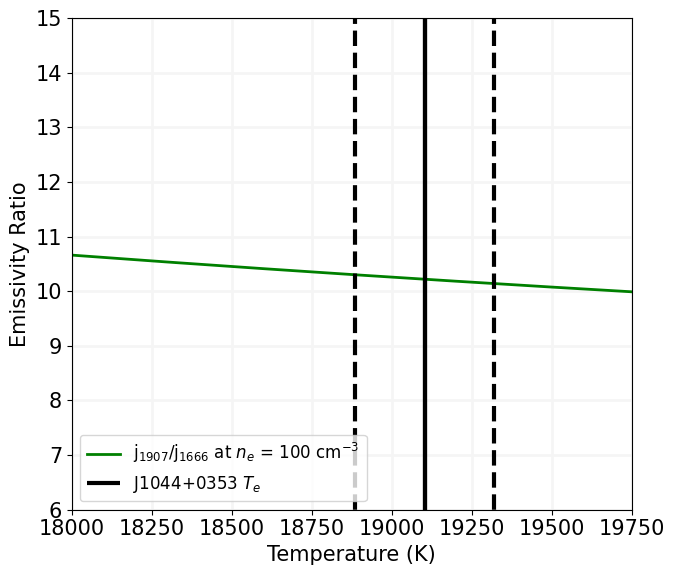

In [42]:
tRang = np.arange(5000,23000,100)

em1907t = C3.getEmissivity(tRang,1e2,wave=1906) # Emissivity as a function of temperature at ne = 100 cm^-3
em1666t = O3.getEmissivity(tRang,1e2,wave=1666) # Emissivity as a function of temperature at ne = 100 cm^-3

#==========================================
plt.figure(figsize=(7,6))
fsize = 15

plt.subplot(1,1,1)
plt.axis([18000,19750,6,15])
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.plot(tRang,em1907t/em1666t,c='green',lw=2,label=r'j$_{1907}$/j$_{1666}$ at $n_e$ = 100 cm$^{-3}$')
plt.vlines([j1044_teO3,j1044_teO3],0,1e3,lw=3,ls='-',color='k',zorder=4,label=r'J1044+0353 $T_e$')
plt.vlines([j1044_teO3-j1044_teO3E,j1044_teO3+j1044_teO3E],0,350,lw=3,ls='--',color='k',zorder=4,label=None)

plt.xlabel('Temperature (K)',fontsize=fsize)
plt.ylabel('Emissivity Ratio',fontsize=fsize)

plt.legend(fontsize=fsize-3,loc=3)

plt.tight_layout()

print('Emissivity Ratio at Te[O III] = %5.1f: %4.2f' % (j1044_teO3,C3.getEmissivity(j1044_teO3,1e2,wave=1906)/O3.getEmissivity(j1044_teO3,1e2,wave=1666)))
print('Emissivity Ratio at Lower Te[O III] = %5.1f: %4.2f' % (j1044_teO3-j1044_teO3E,C3.getEmissivity(j1044_teO3-j1044_teO3E,1e2,wave=1906)/O3.getEmissivity(j1044_teO3-j1044_teO3E,1e2,wave=1666)))

print('Emissivity Ratio at Upper Te[O III] = %5.1f: %4.2f' % (j1044_teO3+j1044_teO3E,C3.getEmissivity(j1044_teO3+j1044_teO3E,1e2,wave=1906)/O3.getEmissivity(j1044_teO3+j1044_teO3E,1e2,wave=1666)))

While this approximation breaks down when the temperature is poorly constrained or when the emissivity ratio is a rapidly varying function of $T_e$, it is adequate for high-quality spectra with well-measured $T_e$. In this way, we can apply a simple propagation of error that accounts for the intensity uncertainty and emissivity uncertainty separately. We can define a function to determine the approximated error in the emissivity and the uncertainty in the ionic abundance:

In [43]:
def emiss_Err(ION1,ION2,line1,line2,te,dte):
    """
    Return the emissivity ratio and the uncertainty in the emissivity ratio of line1/line2
    for a given Te and its uncertainty. Requires the Atom classes ION1 and ION2, the wavelengths
    of line1 and line2, te, and the uncertainty in the temperature dte. Assumed density is 1e2.
    """
    
    #Determine the emissivity ratio at the measured temperature:
    ji = ION1.getEmissivity(te,1e2,wave=line1)/ION2.getEmissivity(te,1e2,wave=line2)
    
    #Determine the emissivity ratio at the lowest temperature, te-dte:
    jL = ION1.getEmissivity(te-dte,1e2,wave=line1)/ION2.getEmissivity(te-dte,1e2,wave=line2)
    
    #Determine the emissivity ratio at the highest temperature, te-dte:
    jU = ION1.getEmissivity(te+dte,1e2,wave=line1)/ION2.getEmissivity(te+dte,1e2,wave=line2)
    
    #Assume that the uncertainty the emissivity (jU-jL)/2
    return ji, (jU-jL)/2

def ionic_abun_err(ION1,ION2,line1,line2,te,dte,inten1,inten1E,inten2,inten2E):
    """
    Function to determine an ionic abundance ratio and its uncertainty. The relative ionic
    abundance calculated is ION1/ION2, using emission lines at wavelengths line1 and line2,
    respectively. te and its uncertainty, dte, are taken as inputs, and the density is
    assumed to be 1e2. The emission line intensities of line1 and line2 are inten1 and
    inten2, respectively. The errors on these intensities are inten1E and inten2E.
    """
    
    #First, determine the intensity ratio and its uncertainty:
    inten_ratio = inten1/inten2
    inten_ratioE= inten_ratio*np.sqrt(np.power(inten1E/inten1,2) + np.power(inten2E/inten2,2))
    
    #Determine the emissivity ratio and its uncertainty:
    emiss_ratio, emiss_ratioE = emiss_Err(ION1,ION2,line1,line2,te,dte)
    
    #Determine ionic abundance:
    ion_abun = inten_ratio/emiss_ratio
    
    #Propagation of Errors:
    ion_abunE = ion_abun*np.sqrt(np.power(inten_ratioE/inten_ratio,2) + np.power(emiss_ratioE/emiss_ratio,2))
    
    return ion_abun, ion_abunE

In [44]:
#Assume 1907 and 1666 uncertainties are symmetric
c3_1907e = (c_1907el[0] + c_1907eu[0])/2
o3_1666e = (c_1666el[0] + c_1666eu[0])/2

#Use the above functions to determine the C++/O++ ionic abundance in J1044+0353
j1044_cppopp, j1044_cppoppE = ionic_abun_err(C3,O3,1907,1666,j1044_teO3,j1044_teO3E,c_1907i[0],c3_1907e,c_1666i[0],o3_1666e)

#Before printing the Ionic Abundance, print relative uncertainties:
j1044_emiss, j1044_emissE = emiss_Err(C3,O3,1907,1666,j1044_teO3,j1044_teO3E)
j1044_inten = c_1907i[0]/c_1666i[0]
j1044_intenE= j1044_inten*np.sqrt(np.power(c3_1907e/c_1907i[0],2) + np.power(o3_1666e/c_1666i[0],2))

print('I([C III]1907) = %3.2f +/- %3.2f' % (c_1907i[0],c3_1907e))
print('I([O III]1666) = %3.2f +/- %3.2f' % (c_1666i[0],o3_1666e))
print()
print('Percent Uncertainty on Emissivity Ratio: %3.2f' % (abs(j1044_emissE/j1044_emiss)*100))
print('Percent Uncertainty on Intensity Ratio:  %3.2f' % (abs(j1044_intenE/j1044_inten)*100))
print()
print('C++/O++ Abundance of ' + c_Names[0] + ' from UV [C III]1907 and [O III]1666: %4.2e +/- %4.2e' % (j1044_cppopp, j1044_cppoppE))

I([C III]1907) = 16.06 +/- 4.50
I([O III]1666) = 11.72 +/- 2.35

Percent Uncertainty on Emissivity Ratio: 0.78
Percent Uncertainty on Intensity Ratio:  34.44

C++/O++ Abundance of J1044+0353 from UV [C III]1907 and [O III]1666: 1.34e-01 +/- 4.62e-02


### 3.5 Total Abundances and Accounting for Unobserved Ionic Species

When all relevant ionic states of an element within a nebula are measured, we can determine the total abundance of that element. The best example is the oxygen abundance, O/H: the main ionic states of O in a typical star-forming galaxy are O$^+$ and O$^{2+}$, with negligible contributions from O$^{3+}$. Therefore, the total O abundance in the ionized region can be described by O/H = O$^+$/H$^+$ + O$^{2+}$/H$^+$. Using the O$^{2+}$/H$^+$ and O$^+$/H$^+$ ionic abundances from the above analysis:

In [45]:
classy_loh = 12+np.log10(classy_Opp + classy_Op)

for i in range(len(classy_Opp)):
    print('12+log(O/H) of ' + c_Names[i] + ': %3.2f' % classy_loh[i])

12+log(O/H) of J1044+0353: 7.46
12+log(O/H) of J1253-0312: 8.04
12+log(O/H) of J1323-0132: 7.74
12+log(O/H) of J1418+2102: 7.61
12+log(O/H) of J1545+0858: 7.75


The UV contains the emission lines of many ions within the nebula, but other ionic states may be present in the nebula that are unobservable in the UV. For example, there should be an amount of C$^+$ in a galaxy with C$^{2+}$ emission, but there are no C$^+$ lines in the UV or optical from which to obtain a C$^+$ abundance. As such, the missing ionic abundances must be corrected for using Ionization Correction Factors (ICFs). If we have the relative abundance X$^{i+}$/O$^{2+}$, we can calculate the abundance X/O using an ICF via

$\frac{X}{O}$ = ICF(X) $\times$ $\frac{X^{+i}}{O^{2+}}$, or log($\frac{X}{O}$) = log(ICF(X)) + log($\frac{X^{+i}}{O^{2+}}$)

ICFs are dependent on the average ionization of the nebula: e.g., a high-ionization nebula will have significnatly more C$^{2+}$ in the gas-phase than C$^+$, and vice-versa for a low-ionization nebula.

The average ionization of the gas is often described by the optical line ratio $O_{32}$=I([O III]5007)/I([O II]3727). The ionization parameter, log(U), which describes the flux of H-ionizing photons in the volume of the H II region, sets the average ionization in the H II region. Photoionization models can be used to relate $O_{32}$ to log(U), and log(U) to the ionic fraction of various elements in the region. For example, Berg+2019 develop various ICF(C) that are polynomial functions of $O_{32}$ and log(U) for select metallicities. This ICF is defined below and is applied to calculate ICF(C) to deterine the C/O abundance from a C$^{2+}$/O$^{2+}$ ionic abundance. Determining the C/O abundance in J1044+0353:

In [46]:
def b19_ICF(lo32,loh):
    """
    Return the Berg+2019 C ICF for an input log(O32) and 12+log(O/H)
    """
    
    #Convert 12+log(O/H) into abundance relative to solar O/H:
    zoh = 10**(loh-12)/10**(8.69-12)
    
    #Define the different polynomial coefficients from Table 3 of Berg+2019:
    # Polynomial for log(U):
    c3_lU_05, c2_lU_05, c1_lU_05 = 0.0887, 0.6941, -3.0390
    c3_lU_10, c2_lU_10, c1_lU_10 = 0.1203, 0.6858, -2.9830
    c3_lU_20, c2_lU_20, c1_lU_20 = 0.1668, 0.6985, -2.9050
    c3_lU_40, c2_lU_40, c1_lU_40 = 0.2231, 0.7774, -2.7610
    
    # Polynomial for ICF(C):
    c4_CICF_05, c3_CICF_05, c2_CICF_05, c1_CICF_05 = 0.3427, 2.3588, 5.6825, 5.7803
    c4_CICF_10, c3_CICF_10, c2_CICF_10, c1_CICF_10 = 0.2807, 1.8670, 4.4009, 4.6543
    c4_CICF_20, c3_CICF_20, c2_CICF_20, c1_CICF_20 = 0.2038, 1.2553, 2.8099, 3.2636
    c4_CICF_40, c3_CICF_40, c2_CICF_40, c1_CICF_40 = 0.1224, 0.5887, 1.0722, 1.7340
    
    #Check metallicity, and select ICF:
    # Select the lowest metallicity models:
    if (zoh <= 0.075):
        logU = c3_lU_05 * np.power(lo32,2) + c2_lU_05 * lo32 + c1_lU_05
        cICF = c4_CICF_05 * np.power(logU,3) + c3_CICF_05 * np.power(logU,2) + c2_CICF_05 * logU + c1_CICF_05
        return cICF
    # Select the 10% solar metallicity models:
    elif (zoh > 0.075) & (zoh <= 0.15):
        logU = c3_lU_10 * np.power(lo32,2) + c2_lU_10 * lo32 + c1_lU_10
        cICF = c4_CICF_10 * np.power(logU,3) + c3_CICF_10 * np.power(logU,2) + c2_CICF_10 * logU + c1_CICF_10
        return cICF
    # Select the 20% solar metallicity models:
    elif (zoh > 0.15) & (zoh <= 0.30):
        logU = c3_lU_20 * np.power(lo32,2) + c2_lU_20 * lo32 + c1_lU_20
        cICF = c4_CICF_20 * np.power(logU,3) + c3_CICF_20 * np.power(logU,2) + c2_CICF_20 * logU + c1_CICF_20
        return cICF
    # Select the highest metallicity models:
    elif (zoh > 0.30):
        logU = c3_lU_40 * np.power(lo32,2) + c2_lU_40 * lo32 + c1_lU_40
        cICF = c4_CICF_40 * np.power(logU,3) + c3_CICF_40 * np.power(logU,2) + c2_CICF_40 * logU + c1_CICF_40
        return cICF

In [47]:
#Determine log(O32) for J1044+0353:
j1044_lo32 = np.log10(c_5007i[0]/c_3727i[0])

#Determine uncertainty in log(O32) for J1044+0353:
j1044_o32E = (c_5007i[0]/c_3727i[0])*np.sqrt(np.power(c_5007e[0]/c_5007i[0],2) + np.power(c_3727e[0]/c_3727i[0],2))
j1044_lo32E = ((np.log(10)*c_5007i[0]/c_3727i[0])**-1) * j1044_o32E

#Determine the ICF for J1044+0353:
j1044_CICF = b19_ICF(j1044_lo32,classy_loh[0])

print('ICF(C) for ' + c_Names[0] + ' using log(O32) of %4.3f +/- %4.3f: ICF(C) = %4.3f' % (j1044_lo32,j1044_lo32E,j1044_CICF))
print()

#Calculate the log(C/O) Abundance in J1044+0353:
j1044_lco = np.log10(j1044_cppopp) + np.log10(j1044_CICF)

#Calculate log(C/O) uncertainty:
j1044_lcoE = ((np.log(10)*j1044_cppopp)**-1) * j1044_cppoppE

print('log(C/O) Abundance for ' + c_Names[0] + ': %3.2f +/- %3.2f' % (j1044_lco,j1044_lcoE))

ICF(C) for J1044+0353 using log(O32) of 1.209 +/- 0.007: ICF(C) = 1.085

log(C/O) Abundance for J1044+0353: -0.84 +/- 0.15


Finally, we can automate the C/O abundances for the 5 CLASSY galaxies and produce a plot of C/O vs O/H. For now we will not calculate the uncertainties on C/O or O/H (this would require the MCMC approach to measure the uncertainty in $T_e$[O III]).

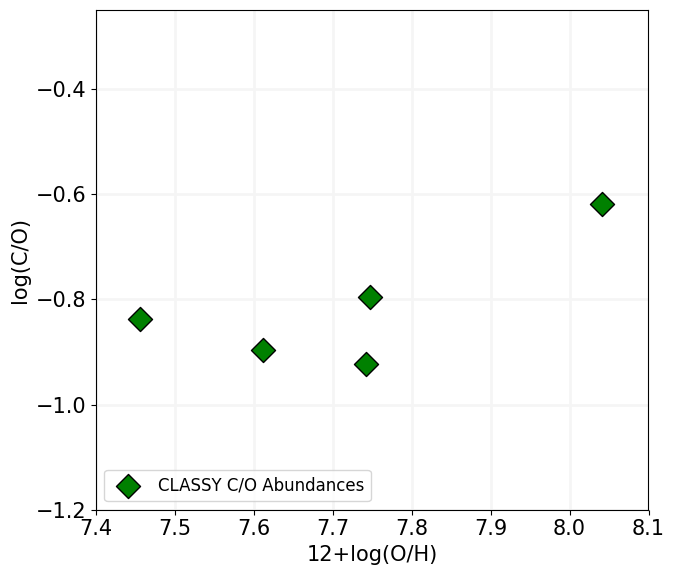

In [48]:
#Obtain log(O32) for all CLASSY galaxies:
classy_lo32 = np.log10(c_5007i/c_3727i)
classy_CICF = []

#Solve for the C ICF for the CLASSY galaxies:
for i in range(len(classy_lo32)):
    classy_CICF.append(b19_ICF(classy_lo32[i],classy_loh[i]))

classy_CICF=np.array(classy_CICF)
classy_lco = np.log10(classy_cppopp) + np.log10(classy_CICF)

#==========================================
plt.figure(figsize=(7,6))
fsize = 15

plt.subplot(1,1,1)
plt.axis([7.4,8.1,-1.2,-0.25])
plt.grid(color='whitesmoke', linestyle='-', linewidth=2,zorder=1)

plt.scatter(classy_loh,classy_lco,marker='D',c='green',edgecolor='k',s=150,label=r'CLASSY C/O Abundances',zorder=5)

plt.xlabel('12+log(O/H)',fontsize=fsize)
plt.ylabel('log(C/O)',fontsize=fsize)

plt.legend(fontsize=fsize-3,loc=3)

plt.tight_layout()